<a href="https://colab.research.google.com/github/dsfsgroup4/customer-sentiment-analysis/blob/main/mcdo_mg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re #pour regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#librairies pour model SentimentIntensityAnalyser
import nltk
from nltk.corpus import stopwords #utilisé pour la tokenisation
from nltk.sentiment import SentimentIntensityAnalyzer #le model utilisé
from nltk.tokenize import word_tokenize #le tokenizer
from collections import Counter #pour word count

from wordcloud import WordCloud # éventuellement utile pour visualiser les top thématiques

from transformers import pipeline #pour model DistilBERT

nltk.download('vader_lexicon') #model utilisé
nltk.download('stopwords') #pour tokenisation
nltk.download('punkt_tab') #nécessaire pour la tokenisation


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv'
path = "/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/Colab Notebooks/Jedha/Projet/McDonald_s_Reviews.csv'


In [3]:
df = pd.read_csv(path, encoding='latin-1')



# Découverte du Dataset:

In [4]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [5]:
df.review[0] #premier commentaire évalué 1 étoile mais attribué positif par le SentimentIntensityAnalyser

'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.'

In [6]:
df.describe(include = "all")
#On constate que des données de latitude et longitude sont manquantes

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
count,33396.000000,33396,33396,33396,32736.000000,32736.000000,33396,33396,33396,33396
unique,NaN,2,1,40,NaN,NaN,51,39,22285,5
top,NaN,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",NaN,NaN,"2,193",4 years ago,Excellent,5 stars
freq,NaN,33325,33396,1890,NaN,NaN,1140,6740,2148,10274
mean,16698.500000,NaN,NaN,NaN,34.442546,-90.647033,NaN,NaN,NaN,NaN
std,9640.739131,NaN,NaN,NaN,5.344116,16.594844,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,25.790295,-121.995421,NaN,NaN,NaN,NaN
25%,8349.750000,NaN,NaN,NaN,28.655350,-97.792874,NaN,NaN,NaN,NaN
50%,16698.500000,NaN,NaN,NaN,33.931261,-81.471414,NaN,NaN,NaN,NaN
75%,25047.250000,NaN,NaN,NaN,40.727401,-75.399919,NaN,NaN,NaN,NaN


In [7]:
df[df.isnull().any(axis = 1)].head(3)
#les valeurs longitudes et latitudes manquantes ont également des adresses incorrectes. il faudra donc les supprimer

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
22141,22142,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",3 months ago,Breakfast specials are good. The sausage burri...,4 stars
22142,22143,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",a year ago,This isn't your typical McDonald's. This place...,5 stars
22143,22144,McDonald's,Fast food restaurant,2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,NaN,NaN,"2,175",2 weeks ago,This place was serving good quality breakfast ...,4 stars


In [8]:
df.store_name.value_counts()
#pas de distinction notable sur les les store_name

,count
store_name,
McDonald's,33325
ýýýMcDonald's,71


In [9]:
df[df.store_name=="ýýýMcDonald's"]

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
500,501,ýýýMcDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 years ago,Tasty as usual,5 stars
1000,1001,ýýýMcDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",2 years ago,It was good food they got my burger right !!,4 stars
1500,1501,ýýýMcDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",4 years ago,Excellent,5 stars
2000,2001,ýýýMcDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",4 years ago,I never ever ever complain but I've had enough...,1 star
2500,2501,ýýýMcDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",4 years ago,Fast worker give them props,4 stars
...,...,...,...,...,...,...,...,...,...,...
31255,31256,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,"Same ol"" ready in 2 minutes food. Idk how they...",2 stars
31755,31756,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,Unique decor. Bad part of town.,3 stars
32255,32256,ýýýMcDonald's,Fast food restaurant,"632 S R L Thornton Freeway Service Rd, Dallas,...",32.744596,-96.812286,"2,658",2 years ago,ýýýýýýýý Terrible service... they never give y...,1 star
32755,32756,ýýýMcDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,They told to wait 7 mnts then she said we are ...,1 star


In [10]:
df.review.sort_values(ascending=False)

,review
6163,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý...
29362,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý
4898,ýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýýý ýýý
15018,ýýýýýýýýýýýýýýýýýýýýý
12379,ýýýýýýýýýýýýýýýýýýýý ýýý
...,...
21773,"""24 hour"" store that is closed...."
7110,"!! Fraud location !! !!!Fraud location !!!, th..."
700,waiting time was longer than expected
661,waiting time was longer than expected


In [11]:
caracteres_speciaux = ["½ï","ý"]
# Créer une expression régulière à partir de la liste
regex_pattern = '|'.join(caracteres_speciaux)

# Filtrer les lignes contenant l'un des caractères spéciaux
filtered_df = df[df['review'].str.contains(regex_pattern, na=False)]

filtered_df #malgré la présence +3000 lignes avec des caractères spéciaux, les commentaires semblent réels et ces caractères peuvent être supprimés lors de la tokenisation

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
7,8,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a year ago,Came in and ordered a Large coffee w/no ice. T...,1 star
9,10,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,"I'm not really a huge fan of fast food, but I ...",4 stars
10,11,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Worst McDonaldï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿...,1 star
...,...,...,...,...,...,...,...,...,...,...
33264,33265,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",3 years ago,I remember this place perfectly. With my broth...,5 stars
33286,33287,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",2 years ago,Double Mac cheese burger extra bacon li yï¿½ï¿½,5 stars
33292,33293,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",6 years ago,"I had a good experience, the girl who helped m...",5 stars
33365,33366,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,They have improved the waiting time ï¿½ï,4 stars


# Cleaning

In [12]:
df1 = df.copy()
df1 = df1.dropna() #retirer les lignes sans latitude / longitude car leur adresse est invalide

In [13]:
# Drop columns 'reviewer_id', 'store_name', 'category'
df1 = df1.drop(columns=['reviewer_id','store_name', 'category'])


In [14]:
df1[['City', 'State']] = df1['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))



In [15]:
df1["rating"] = (df1["rating"].str.split(" ").str[0].astype(int))


In [16]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def parse_relative_date(s, current_date):
    # Remove extra whitespace and split the string
    parts = s.strip().split()
    if len(parts) != 3:
        return None
    # Check if the number is represented as "a" or "an"
    num_str = parts[0].lower()
    if num_str in ['a', 'an']:
        num = 1
    else:
        try:
            num = int(num_str)
        except ValueError:
            return None

    unit = parts[1].lower()

    # Adjust the current date based on the unit
    if 'day' in unit:
        abs_date = current_date - pd.Timedelta(days=num)
    elif 'month' in unit:
        abs_date = current_date - relativedelta(months=num)
    elif 'year' in unit:
        abs_date = current_date - relativedelta(years=num)
    else:
        return None

    # Normalize to remove the time (sets time to 00:00:00)
    return abs_date.normalize()

#Get the current date
current_date = pd.Timestamp.now()

#Apply the function to create a new column with the actual dates
df1['review_date'] = df1['review_time'].apply(lambda x: parse_relative_date(x, current_date))


In [17]:
def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review) # retirer les caractères spéciaux
    review = re.sub(r'\s+', ' ', review).strip() # retirer les espaces
    review = re.sub(r'http\S+|www\S+', '', review) # retirer les URLs

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    stop_words.update(mot_a_sup)
    review = ' '.join([word for word in review_tokens if word not in stop_words])


    return review

df1['clean_reviews'] = df1['review'].apply(clean_review)


In [18]:
def liked (data):
    if data['rating'] > 3:
      return "POSITIF"
    elif data["rating"] ==3:
      return "NEUTRE"
    else:
      return "NEGATIF"

df1['liked'] = df1.apply(liked, axis = 1)


In [19]:
df1.head()

,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked
0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,Austin,TX 78750,2025-01-02,look like someone spit food normal transaction...,NEGATIF
1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,Austin,TX 78750,2025-03-28,itd far food atmosphere go staff make differen...,POSITIF
2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1,Austin,TX 78750,2025-03-28,made mobile order got speaker checked line mov...,NEGATIF
3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,Austin,TX 78750,2025-03-02,mc crispy chicken sandwich customer service qu...,POSITIF
4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX 78750,2025-02-02,repeat order times drive thru still manage mes...,NEGATIF


In [20]:
df1.describe(include="all")

,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked
count,32736,32736.000000,32736.000000,32736,32736,32736,32736.000000,32736,32736,32309,32736,32736
unique,39,NaN,NaN,50,39,21634,NaN,26,36,NaN,20328,3
top,"9814 International Dr, Orlando, FL 32819, Unit...",NaN,NaN,"2,052",4 years ago,Excellent,NaN,New York,FL 32819,NaN,excellent,POSITIF
freq,1890,NaN,NaN,1140,6633,2148,NaN,3486,2380,NaN,2178,15705
mean,NaN,34.442546,-90.647033,NaN,NaN,NaN,3.126283,NaN,NaN,2022-05-16 14:45:57.299823872,NaN,NaN
min,NaN,25.790295,-121.995421,NaN,NaN,NaN,1.000000,NaN,NaN,2013-04-02 00:00:00,NaN,NaN
25%,NaN,28.655350,-97.792874,NaN,NaN,NaN,1.000000,NaN,NaN,2021-04-02 00:00:00,NaN,NaN
50%,NaN,33.931261,-81.471414,NaN,NaN,NaN,3.000000,NaN,NaN,2022-04-02 00:00:00,NaN,NaN
75%,NaN,40.727401,-75.399919,NaN,NaN,NaN,5.000000,NaN,NaN,2024-04-02 00:00:00,NaN,NaN
max,NaN,44.981410,-73.459820,NaN,NaN,NaN,5.000000,NaN,NaN,2025-04-01 00:00:00,NaN,NaN


# EDA

In [21]:
df1["liked"].value_counts(normalize=True, dropna=False) * 100

,proportion
liked,
POSITIF,47.974707
NEGATIF,37.649682
NEUTRE,14.375611


In [22]:
df1["rating"].value_counts(normalize=True, dropna=False) * 100

,proportion
rating,
5,30.727639
1,28.424365
4,17.247067
3,14.375611
2,9.225318


In [23]:
df1["City"].value_counts(normalize=True, dropna=False) * 100

,proportion
City,
New York,10.648827
Orlando,9.439150
Austin,5.272483
Kissimmee,5.254154
North Hollywood,5.223607
Fern Park,5.193060
Dallas,5.040323
Miami,4.795943
Newark,3.940616


In [24]:
df1["State"].value_counts(normalize=True, dropna=False) * 100

,proportion
State,
FL 32819,7.270283
NY 10001,6.323314
FL 34746,5.254154
CA 91602,5.223607
FL 32730,5.193060
TX 75203,5.040323
FL 33137,4.795943
NJ 07104,3.940616
TX 76262,3.567937


# Sentiment analyser

In [25]:
df2 = df1.copy()

## model SentimentIntensityAnalyser

In [26]:
analyzer = SentimentIntensityAnalyzer()

#Sentiment score compris entre -1 (très négatif) et 1 (très positif)
df2['sentiment_score_SIA'] = df2['clean_reviews'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
df2['sentiment_SIA'] = None

df2['sentiment_SIA'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else ('negative' if score <= -0.1 else 'neutral'))
print(df2[['sentiment_score_SIA', 'sentiment_SIA', 'liked']].head())

   sentiment_score_SIA sentiment_SIA    liked
0               0.5541      positive  NEGATIF
1               0.8591      positive  POSITIF
2              -0.2960      negative  NEGATIF
3               0.0000       neutral  POSITIF
4              -0.7184      negative  NEGATIF


In [27]:
df2["sentiment_SIA"].value_counts(normalize=True, dropna=False) * 100

,proportion
sentiment_SIA,
positive,46.432063
neutral,28.983382
negative,24.584555


In [28]:
#rappel de la répartition des liked pour comparaison
df2["liked"].value_counts(normalize=True, dropna=False) * 100

,proportion
liked,
POSITIF,47.974707
NEGATIF,37.649682
NEUTRE,14.375611


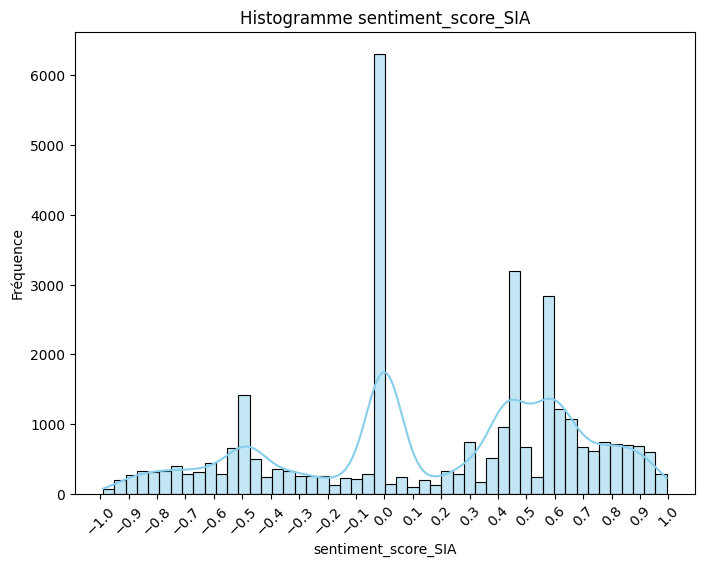

In [29]:
plt.figure(figsize=(8, 6))
sns.histplot(df2["sentiment_score_SIA"], bins=50, kde=True, color='skyblue', edgecolor='black')

plt.xlabel('sentiment_score_SIA')
plt.ylabel('Fréquence')
plt.title('Histogramme sentiment_score_SIA')

plt.xticks(rotation=45)  # Fait pivoter les étiquettes de 45 degrés
plt.xticks(np.arange(-1, 1.1, 0.1))  # Ajoute des graduations tous les 0.1 entre -1 et 1

# Afficher l'histogramme
plt.show()

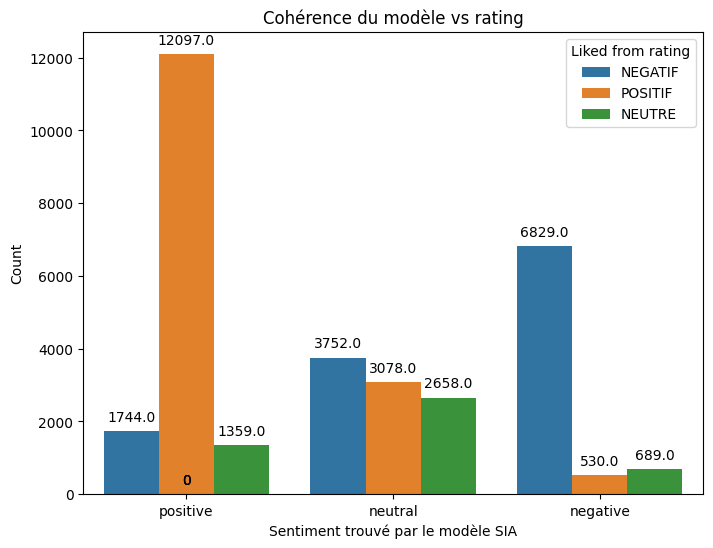

In [30]:
plt.figure(figsize=(8, 6))

# Créer le countplot
ax = sns.countplot(x='sentiment_SIA', hue='liked', data=df2, order=df2['sentiment_SIA'].value_counts().index)


# Ajouter les effectifs sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

'''
# Calculer les pourcentages
total = df2.groupby(['sentiment_SIA', 'liked']).size().unstack().fillna(0)

# Annoter les barres avec les pourcentages
for p in ax.patches:
    sentiment = p.get_x() + p.get_width() / 2  # Position x de la barre
    height = p.get_height()
    sentiment_category = df2['sentiment_SIA'].unique()[int(sentiment)]
    liked_category = df2['liked'].unique()[int(p.get_x()) % len(df2['liked'].unique())]
    group_total = total.loc[sentiment_category, liked_category]
    total_count = total.loc[sentiment_category].sum()
    percentage = f'{(height / total_count * 100):.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

'''
# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Obtenir les handles et les labels de la légende
handles, labels = ax.get_legend_handles_labels()

# Créer une légende unique
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title='Liked from rating')

# Afficher le graphique
plt.show()



In [31]:
analyzer = SentimentIntensityAnalyzer() #model sans neutres

#Sentiment score compris entre -1 (très négatif) et 1 (très positif)
df2['sentiment_score_SIA2'] = df2['clean_reviews'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
df2['sentiment_SIA2'] = None
df2['sentiment_SIA2'] = df2['sentiment_score_SIA2'].apply(lambda score: 'positive' if score >= 0.4 else 'negative')
print(df2[['sentiment_score_SIA2', 'sentiment_SIA2', 'liked']].head())

   sentiment_score_SIA2 sentiment_SIA2    liked
0                0.5541       positive  NEGATIF
1                0.8591       positive  POSITIF
2               -0.2960       negative  NEGATIF
3                0.0000       negative  POSITIF
4               -0.7184       negative  NEGATIF


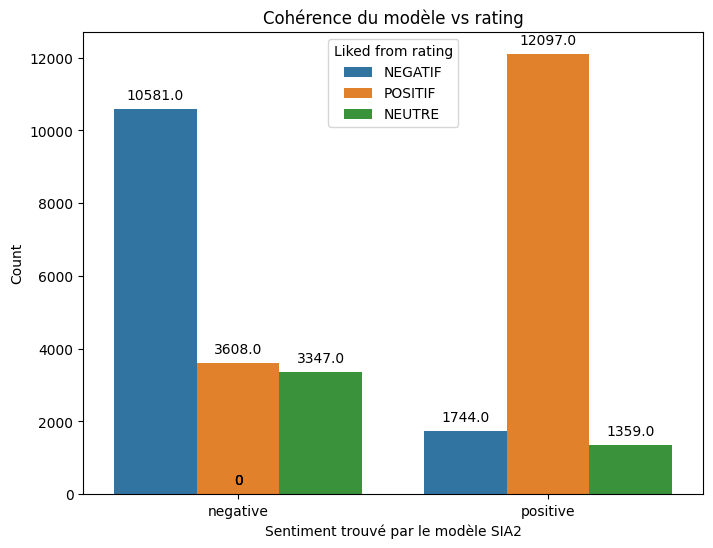

In [32]:
plt.figure(figsize=(8, 6))

# Créer le countplot
ax = sns.countplot(x='sentiment_SIA2', hue='liked', data=df2, order=df2['sentiment_SIA2'].value_counts().index)

'''
# Calculer les pourcentages
total = df2.groupby(['sentiment_SIA2', 'liked']).size().unstack().fillna(0)
total_sum = total.sum(axis=1)

# Annoter les barres avec les pourcentages
for i, p in enumerate(ax.patches):
    sentiment = p.get_x() + p.get_width() / 2  # Position x de la barre
    liked_index = i % len(df2['liked'].unique())  # Index de 'liked'
    height = p.get_height()
    percentage = f'{(height / total_sum.iloc[int(sentiment)] * 100):.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
'''
# Ajouter les effectifs sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating')
plt.xlabel('Sentiment trouvé par le modèle SIA2')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Obtenir les handles et les labels de la légende
handles, labels = ax.get_legend_handles_labels()

# Créer une légende
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title='Liked from rating')

# Afficher le graphique
plt.show()

## Model Text_classification from DistilBERT

In [33]:
#le model est trop gros pour être testé sur les 33000 lignes du dataset. nous le testons donc sur un sample de 3500
df2_sample=df2[df2["City"]=="New York"]

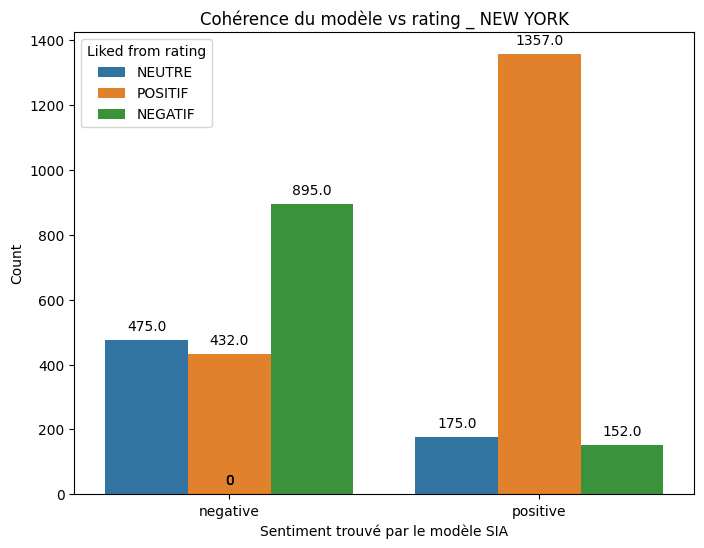

In [34]:
# Rappel résultats du model SIA2 filtré sur NY
plt.figure(figsize=(8, 6))

# Créer le countplot
ax = sns.countplot(x='sentiment_SIA2', hue='liked', data=df2_sample, order=df2_sample['sentiment_SIA2'].value_counts().index)


# Ajouter les effectifs sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating _ NEW YORK')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Obtenir les handles et les labels de la légende
handles, labels = ax.get_legend_handles_labels()

# Créer une légende unique
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title='Liked from rating')

# Afficher le graphique
plt.show()

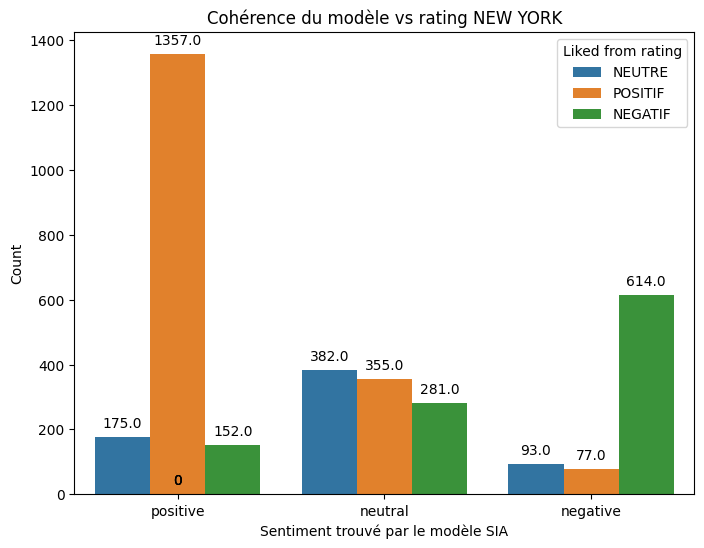

In [35]:
# Rappel résultats du model SIA2 filtré sur NY
plt.figure(figsize=(8, 6))

# Créer le countplot
ax = sns.countplot(x='sentiment_SIA', hue='liked', data=df2_sample, order=df2_sample['sentiment_SIA'].value_counts().index)

# Ajouter les effectifs sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Ajouter un titre et des labels
plt.title('Cohérence du modèle vs rating NEW YORK')
plt.xlabel('Sentiment trouvé par le modèle SIA')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Obtenir les handles et les labels de la légende
handles, labels = ax.get_legend_handles_labels()

# Créer une légende unique
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title='Liked from rating')

# Afficher le graphique
plt.show()

In [36]:
#test du model distilbert
pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #model par défaut. tronqué car il ne support pas les reviews de plus de 512 tokens
reviews = df2_sample["review"].tolist()
df2_sample['text_classification'] = pipe(reviews)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu
<ipython-input-36-1c83b4f53357>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_sample['text_classification'] = pipe(reviews)


In [37]:
for i in df2_sample.index:
    df2_sample.loc[i, "sentiment_TC"] = df2_sample.loc[i, "text_classification"]["label"]
    df2_sample.loc[i, "score_TC"] = df2_sample.loc[i, "text_classification"]["score"]
df2_sample.drop(["text_classification"],axis = 1)

<ipython-input-37-d3d346ec8df5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_sample.loc[i, "sentiment_TC"] = df2_sample.loc[i, "text_classification"]["label"]
<ipython-input-37-d3d346ec8df5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_sample.loc[i, "score_TC"] = df2_sample.loc[i, "text_classification"]["score"]


,store_address,latitude,longitude,rating_count,review_time,review,rating,City,State,review_date,clean_reviews,liked,sentiment_score_SIA,sentiment_SIA,sentiment_score_SIA2,sentiment_SIA2,sentiment_TC,score_TC
2968,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",a year ago,Visited this location for breakfast. The place...,3,New York,NY 10001,2024-04-02,visited location breakfast place small better ...,NEUTRE,0.9015,positive,0.9015,positive,POSITIVE,0.986821
2969,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",a year ago,From cleanliness to freshness to the fast cust...,5,New York,NY 10001,2024-04-02,cleanliness freshness fast customer service st...,POSITIF,0.7579,positive,0.7579,positive,POSITIVE,0.996774
2970,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",3 months ago,McDonalds was great! The food tastes like in U...,5,New York,NY 10001,2025-01-02,great food tastes like ukraine europe fried po...,POSITIF,0.8860,positive,0.8860,positive,NEGATIVE,0.992124
2971,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",a month ago,Thursday at 2:56 am. I went in here to order. ...,1,New York,NY 10001,2025-03-02,thursday went order unfriendly rude guard sits...,NEGATIF,-0.9139,negative,-0.9139,negative,NEGATIVE,0.996790
2972,"429 7th Ave, New York, NY 10001, United States",40.750506,-73.990583,"2,052",4 days ago,"It is a 24 hr location, when I arrived and tri...",1,New York,NY 10001,2025-03-29,hr location arrived tried order use restroom t...,NEGATIF,-0.7430,negative,-0.7430,negative,NEGATIVE,0.994900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10085,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,6 years ago,The cashiers are very nice and the place is co...,5,New York,NY 10001,2019-04-02,cashiers nice place comfortable great place in...,POSITIF,0.8807,positive,0.8807,positive,POSITIVE,0.999825
10086,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,3 years ago,The security will kick you out if you don't fi...,2,New York,NY 10001,2022-04-02,security kick dont finish food mins sooo shock...,NEGATIF,0.0258,neutral,0.0258,negative,NEGATIVE,0.970577
10087,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,5 years ago,"Fast service, although the table service which...",3,New York,NY 10001,2020-04-02,fast service although table service supposed w...,NEUTRE,-0.3720,negative,-0.3720,negative,POSITIVE,0.999618
10088,"151 West 34th Street (Macy's 7th Floor, New Yo...",40.750831,-73.989096,263,3 years ago,To avoid ! Restaurant room very small. Sad for...,1,New York,NY 10001,2022-04-02,avoid restaurant room small sad store floors e...,NEGATIF,-0.2732,negative,-0.2732,negative,NEGATIVE,0.999788


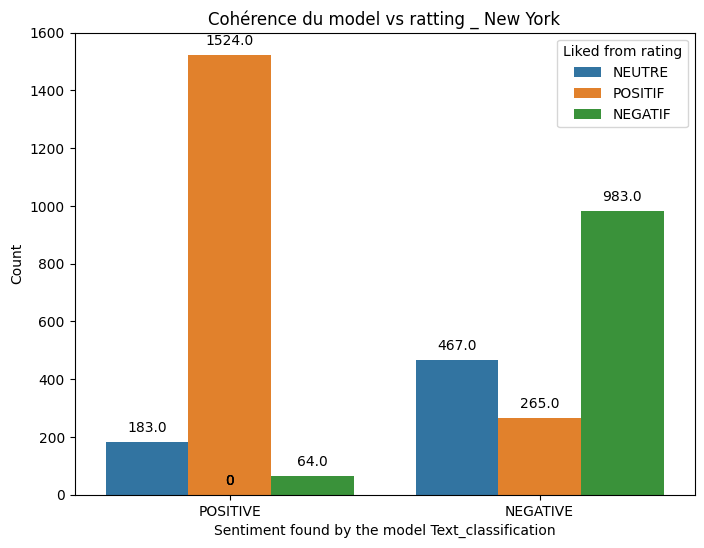

In [38]:
plt.figure(figsize=(8, 6))
# Créer le countplot
ax = sns.countplot(x='sentiment_TC', hue='liked', data=df2_sample, order=df2_sample['sentiment_TC'].value_counts().iloc[:10].index)

# Ajouter les effectifs sur les barres
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Cohérence du model vs ratting _ New York')
plt.xlabel('Sentiment found by the model Text_classification')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Liked from rating')
plt.show()

Une meilleure attribution des positif, mais davantage de faux négatifs

# Trouver les thématiques

rappel : les reviews ont été cleanés tokenisés par par cett fonction :

def clean_review(review):
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review) # retirer les caractères spéciaux
    review = re.sub(r'\s+', ' ', review).strip() # retirer les espaces
    review = re.sub(r'http\S+|www\S+', '', review) # retirer les URLs

    stop_words = set(stopwords.words('english'))
    review_tokens = nltk.word_tokenize(review) #methode de tokenisation efficace pour le langage courant (contractions de mots, ponctuation...)
    mot_a_sup = ["mcdonalds", "one"] #mots trop fréquents dans les commentaires
    stop_words.update(mot_a_sup)
    review = ' '.join([word for word in review_tokens if word not in stop_words])

   
    return review

In [40]:
df2['word_list'] = df2['clean_reviews'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df2['word_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,food,7616
1,service,6067
2,order,6030
3,good,5462
4,place,3298
5,get,3248
6,drive,2825
7,fast,2622
8,time,2561
9,like,2530


In [41]:
Positive_sent = df2[df2['sentiment_SIA'] == 'positive']
Negative_sent = df2[df2['sentiment_SIA'] == 'negative']

top = Counter([item for sublist in df2[df2['sentiment_SIA'] == 'positive']['word_list'] for item in sublist])
positive_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
positive_words.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,4851
1,food,3659
2,service,3009
3,excellent,2509
4,great,2100
5,order,1789
6,place,1740
7,clean,1711
8,fast,1548
9,staff,1344


In [42]:
top = Counter([item for sublist in df2[df2['sentiment_SIA'] == 'negative']['word_list'] for item in sublist])
negative_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
negative_words.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,2804
1,food,2246
2,service,1991
3,get,1289
4,worst,1077
5,drive,1064
6,rude,1040
7,bad,1034
8,time,993
9,place,982
